This notebook is for ACEsig training and validation. Please clone our GitHub repository first by running the following commands in the terminal:
```
git clone https://github.com/Tang-RH/sciNMF.git
cd sciNMF
```
After that, you can run this tutorial Jupyter notebook.  
Below is the workflow for ACEsig training:

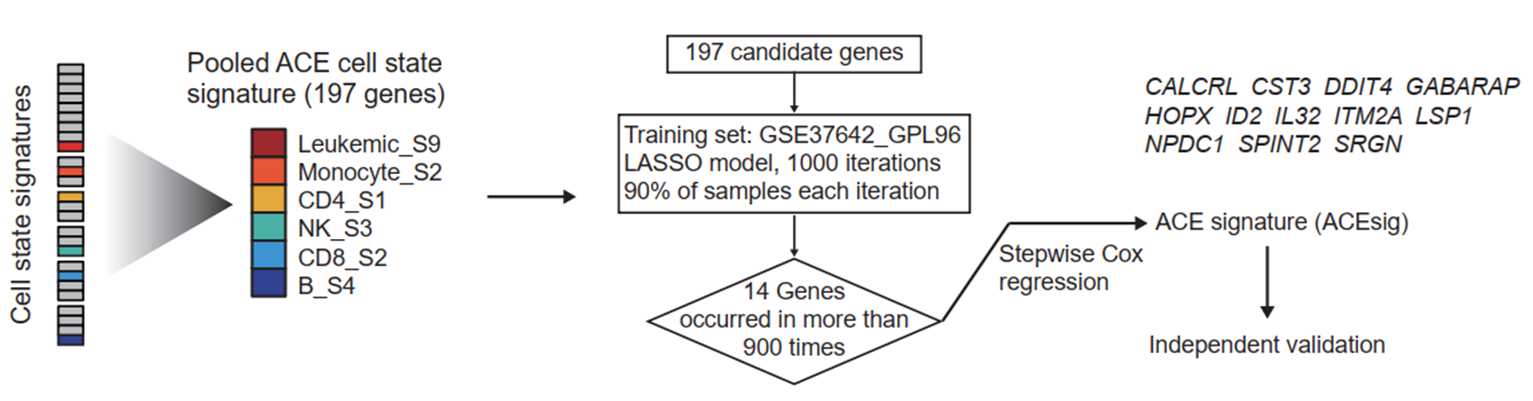

In [1]:
library(magrittr)
library(ggplot2)
library(dplyr)
library(survminer)
library(survival)
library(cowplot)
library(paletteer)
library(parallel)
library(RColorBrewer)
library(glmnet)
library(ggalluvial)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggpubr


Attaching package: ‘survival’


The following object is masked from ‘package:survminer’:

    myeloma



Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


Loading required package: Matrix

Loaded glmnet 4.1-8



# Preparation

## Celluar states

In [2]:
# all celluar states (meta pragrams) developed in our study are save in "Data/ls_MP.rds"
ls_MP <- readRDS('Data/ls_MP.rds')
sapply(ls_MP, head)

Leukemic_S1,Leukemic_S2,Leukemic_S3,Leukemic_S4,Leukemic_S5,Leukemic_S6,Leukemic_S7,Leukemic_S8,Leukemic_S9,CD8_S1,⋯,CD4_S1,CD4_S2,CD4_S3,DC_S1,DC_S2,DC_S3,DC_S4,Monocyte_S1,Monocyte_S2,Monocyte_S3
TUBA1B,MALAT1,AZU1,FTH1,SPINK2,SLC40A1,CRIP1,FOS,JCHAIN,NKG7,⋯,S100A4,JUN,LINC00861,STMN1,JCHAIN,PSAP,FTH1,NAMPT,CD74,STMN1
STMN1,NEAT1,SRGN,TPM4,CDK6,SOX4,VIM,CXCL8,CD36,GNLY,⋯,IL32,FOS,LEF1,H2AFZ,IRF7,CTSS,PLIN2,CXCL8,HLA-DRA,HMGN2
H2AFZ,NKTR,MPO,H1FX,ANGPT1,GATA2,S100A10,DUSP1,SPINK2,GZMA,⋯,KLRB1,ZFP36,ATM,HMGB2,SOX4,MS4A7,SAT1,NEAT1,HLA-DRB5,TUBA1B
TUBB,LUC7L3,CTSG,DDIT3,SERPINB1,CNRIP1,LGALS1,JUN,CD99,GZMH,⋯,CCL5,JUNB,SELL,TUBB,PLD4,S100A4,LYZ,S100A12,HLA-DRB1,H2AFZ
HIST1H4C,PNISR,LYZ,GNA15,SOX4,PLEK,TAGLN2,EGR1,CD34,IL32,⋯,LGALS1,DUSP1,MALAT1,DUT,CD74,FCN1,S100A10,IFITM2,HLA-DPA1,HIST1H4C
HMGB2,MDM4,ELANE,SYAP1,TPM4,FCER1A,LMNA,NFKBIA,GLIPR1,S100A4,⋯,S100A10,NFKBIA,EEF1B2,SAMHD1,MZB1,TNFRSF1B,CFD,SAT1,HLA-DPB1,TUBB


In [3]:
# the ACE celluar sates
ACE <- c('Monocyte_S2','CD4_S1','NK_S3','CD8_S2','B_S4','Leukemic_S9')
ls_ACE_MP <- ls_MP[ACE]

## Data loading

In [4]:
ls_bulk <- readRDS('Data/rna_list.rds')
ls_cli <- readRDS('Data/clinic_list.rds')

In [5]:
# Sample sizes of each cohort enrolled in this study
sapply(ls_bulk, ncol)

GSE37642_GPL96           TCGA 
           417            179

In [6]:
# set GSE37642_GPL96 as training set
bulk_train <- ls_bulk[['GSE37642_GPL96']]
cli_train <- ls_cli[['GSE37642_GPL96']]

In [7]:
all_genes <- lapply(ls_bulk, rownames) %>% 
    Reduce(f = intersect)
length(all_genes)

[1] 11896

# Training

## 1000 times LASSO cox regression

In [8]:
# perfrom LASSO regression to select key genes
times <- 1000
#for leave 10% out cross validation
nfold <- 10
seeds <- 1:times
freq_cut <- 0.9*times

#for ACE gene
gene_used <- ls_ACE_MP %>% unlist %>% unique

ls_mds <- mclapply(seeds, mc.cores = 20,function(seed){
    # train the ACEsig with all gene from ACE celluar states
    gene_used <- intersect(rownames(bulk_train), gene_used)
    exp <- bulk_train[gene_used,]
    x <- as.matrix(t(exp))
    y <- cli_train[, c("OS.time", "OS.status")]
    y$OS.time <- as.double(y$OS.time)
    y$OS.status <- as.double(y$OS.status)
    y <- as.matrix(Surv(y$OS.time, y$OS.status))
    set.seed(seed)
    lasso_fit <- cv.glmnet(x, y, family = "cox", type.measure = "deviance", 
        alpha = 1, nfolds = nfold)
    lambda_best <- lasso_fit$lambda.min
    coefficient <- coef(lasso_fit, s = lambda_best)
    active_index <- which(as.numeric(coefficient) != 0)
    active_coef <- as.numeric(coefficient)[active_index]
    active_gene <- rownames(coefficient)[active_index]
    model <- list(active_gene = active_gene, active_coef = active_coef)
    return(model)
})

df_gene_freq <- lapply(ls_mds, '[[', 'active_gene') %>% unlist %>%
    table %>% data.frame %>% arrange(-Freq)
colnames(df_gene_freq)[1] <- 'Gene'

In [9]:
dim(df_gene_freq)
# there are 14 genes appear over 900 times
df_gene_freq[df_gene_freq$Freq >= freq_cut,]

[1] 41  2

,Gene,Freq
,<fct>,<int>
1,CALCRL,1000
2,CST3,1000
3,DDIT4,1000
4,FXYD5,1000
5,GABARAP,1000
6,HINT1,1000
7,HOPX,1000
8,ID2,1000
9,IL32,1000


## Setpwise Cox Regression

In [10]:
gene_candidate <- df_gene_freq$Gene[df_gene_freq$Freq >= freq_cut] %>% as.character

In [11]:
# "both" direction stepwise cox regression
mat_train_cox <- cbind(t(bulk_train[gene_candidate,]),cli_train[,c('OS.time','OS.status')])
fit <- step(coxph(Surv(OS.time,OS.status)~.,mat_train_cox),direction = "backward")
md_ACE <- coef(fit)

Start:  AIC=3253.02
Surv(OS.time, OS.status) ~ CALCRL + CST3 + DDIT4 + FXYD5 + GABARAP + 
    HINT1 + HOPX + ID2 + IL32 + ITM2A + LSP1 + NPDC1 + SPINT2 + 
    SRGN

          Df    AIC
- HINT1    1 3251.6
- FXYD5    1 3252.0
<none>       3253.0
- ID2      1 3253.5
- NPDC1    1 3254.0
- GABARAP  1 3254.6
- LSP1     1 3255.2
- SRGN     1 3255.5
- CST3     1 3256.1
- IL32     1 3256.3
- ITM2A    1 3256.7
- CALCRL   1 3257.0
- DDIT4    1 3257.1
- HOPX     1 3259.7
- SPINT2   1 3260.2

Step:  AIC=3251.61
Surv(OS.time, OS.status) ~ CALCRL + CST3 + DDIT4 + FXYD5 + GABARAP + 
    HOPX + ID2 + IL32 + ITM2A + LSP1 + NPDC1 + SPINT2 + SRGN

          Df    AIC
- FXYD5    1 3250.9
<none>       3251.6
- NPDC1    1 3252.3
- ID2      1 3253.2
- GABARAP  1 3254.0
- IL32     1 3254.7
- SRGN     1 3254.7
- CST3     1 3254.9
- DDIT4    1 3255.1
- LSP1     1 3255.3
- ITM2A    1 3255.6
- CALCRL   1 3256.2
- HOPX     1 3258.0
- SPINT2   1 3258.8

Step:  AIC=3250.85
Surv(OS.time, OS.status) ~ CALCRL + CST3 + 

In [12]:
# the final ACEsig model
md_ACE

CALCRL       CST3      DDIT4    GABARAP       HOPX        ID2       IL32 
 0.5167056 -0.1353774  0.1470118 -0.5034543  0.1104565  0.1395162 -0.3102823 
     ITM2A       LSP1      NPDC1     SPINT2       SRGN 
-0.1517907  0.2237986  0.1108197  0.2453311  0.3823752

# Validation

## ACEsig function

In [13]:
# This function is used to calculate the ACE score and classify the patients into high and low risk groups based on the median of the ACE score
# The input is expression matrix, whose rows represent genes and columns represent patients
# return value is a dataframe object, frist column is 'ACEScore' cacluated by the ACE model, the second column is 'Risk' classification 
ACEsig <- function(mat){
    model <- c('CALCRL'=0.516705634819962,
              'CST3'=-0.135377434640815,
              'DDIT4'=0.147011776933904,
              'GABARAP'=-0.503454274985267,
              'HOPX'=0.110456507784065,
              'ID2'=0.139516214077651,
              'IL32'=-0.310282298890454,
              'ITM2A'=-0.151790695494774,
              'LSP1'=0.223798555072212,
              'NPDC1'=0.110819689132806,
              'SPINT2'=0.245331132788398,
              'SRGN'=0.382375238214482)
    genes <- names(model)
    idx_g <- genes %in% rownames(mat)
    if(any(!idx_g)){
        warning('Gene: ', paste0(genes[!idx_g],collapse = ', '), ' are(is) absent in your expression matrix')
    }
    coeff <- model[idx_g]
    Score <- apply(mat[names(coeff),], 2, function(x){
        sum(x*coeff)
    })
    cat('Median Cutoff is ', median(Score))
    Risk <- ifelse(Score > median(Score), "ACEhi", "ACElo")
    Patient <- colnames(mat)
    df_res <- data.frame(Patient = Patient, Score = Score, Risk = Risk)
    df_res$Risk <- factor(df_res$Risk, levels = c("ACElo", "ACEhi"))
    rownames(df_res) <- Patient
    return(df_res)
}

In [14]:
# function for KM curve
KMplot <- function(data, risk_column = "risk", title = "Test 1"){
    data$label <- data[,risk_column]
    # calculate log-rank p value
    survtest <- survdiff(Surv(OS.time,OS.status) ~ label, data=data)
    p <- 1 - pchisq(survtest$chisq, 1)
    pval <-  paste0("Log-rank p = ", format(p, scientific = TRUE, digits = 2))
    # calculate C-index
    coxmodel <- coxph(Surv(OS.time,OS.status) ~ label, data=data)
    sum.surv <- summary(coxmodel)
    Cindex <- sum.surv$concordance[1]
    Cindex <- paste0("C-index = ", round(Cindex,2))
    # calculate HR
    HR<-sum.surv$conf.int[1]
    CI<-sum.surv$conf.int[3:4]
    CI <- paste(round(CI[1],2), round(CI[2],2), sep='-')
    CI <- paste0('[',CI, ']')
    HR <- paste(round(HR,2), CI, sep=', ')
    HR <- paste0("HR = ", HR)
    # plot KM curve
    fit <- survfit(Surv(OS.time,OS.status) ~ label, data = data)
    p <- ggsurvplot(fit, data = data, 
                   palette = c("#00468b", "#ed0000"), 
                   # conf.int = T,conf.int.style='step', 
                   #pval.method = TRUE, pval.method.coord=c(1,0.3), pval.method.size=5,
                   pval = TRUE, pval.coord=c(1,0.2),pval.size=5,
                   risk.table = TRUE, risk.table.pos='in',
                   legend="none", legend.title="", 

				   legend.labs=levels(data$label), 
                   title=title, 
				   #break.x.by = 30,
                   ggtheme = theme_bw(base_size = 15)
                   )
    p$plot <- p$plot + theme(panel.grid = element_blank()) + xlab("Survival time (months)") +
                #annotate("text", x = 1, y= 0.17, label = pval, size=5, hjust=0) + 
                #annotate("text", x = 1, y= 0.1, label = Cindex, size=5, hjust=0) + 
                annotate("text", x = 1, y = 0.3, label = HR,size=5, hjust=0)
    # p$plot <- p$plot + 
	# 			annotate("text", x = 1, y= 0.25, label = pval, size=5, hjust=0) +
	# 			annotate("text", x = 1, y = 0.15, label = HR, size=5, hjust=0)

    return(p)
}

## Prognosis Value

In [15]:
# KM curve in training set and TCGA dataset
bulk_train <- ls_bulk[['GSE37642_GPL96']]
cli_train <- ls_cli[['GSE37642_GPL96']]

bulk_TCGA <- ls_bulk[['TCGA']]
cli_TCGA <- ls_cli[['TCGA']]

In [16]:
# calculate the ACEsig score for each dataset
cat('GSE37642_GPL96\n')
cli_train <- cbind(cli_train, ACEsig(bulk_train))
cat('\nTCGA\n')
cli_TCGA <- cbind(cli_TCGA, ACEsig(bulk_TCGA))

GSE37642_GPL96
Median Cutoff is  6.626373
TCGA
Median Cutoff is  1.684511

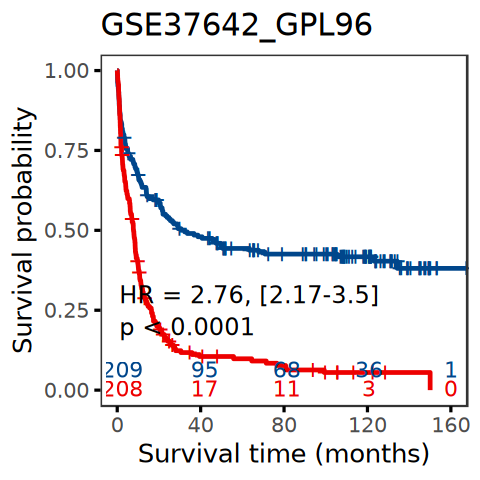

In [17]:
# training set KM curve
options(repr.plot.width=4, repr.plot.height=4)
KMplot(cli_train, risk_column = "Risk", title = 'GSE37642_GPL96')

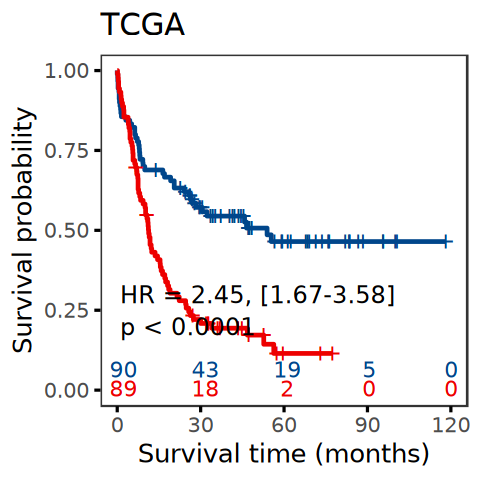

In [18]:
# KM curve for TCGA
options(repr.plot.width=4, repr.plot.height=4)
KMplot(cli_TCGA, risk_column = "Risk", title = 'TCGA')

In [19]:
# Sankey plot
df_sankey <- cli_TCGA[,c("Risk", "CytogeneticRisk")]
df_sankey <- df_sankey %>% filter(CytogeneticRisk %in% c('Good', 'Intermediate', 'Poor'))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


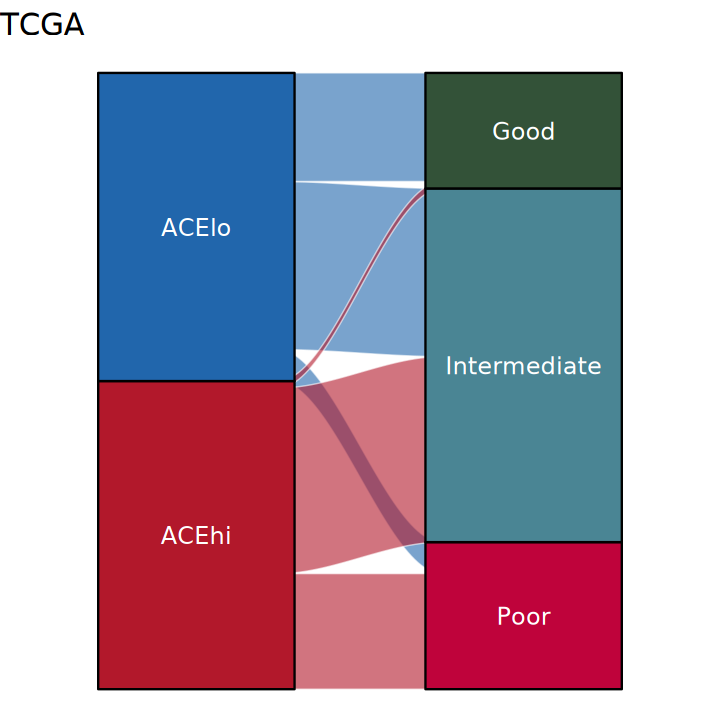

In [20]:
# Sankey diagram
data_sankey <- to_lodes_form(df_sankey, axes = 1:ncol(df_sankey), id = "value")
col <- c("#2166ac", "#b2182b", '#335238', '#4a8594', '#bf033b')
p <- ggplot(data_sankey, aes(x = x, fill=stratum, label=stratum,
                   stratum = stratum, alluvium  = value))+#数据
      geom_flow(width = 0.5,#连线宽度
                curve_type = "cubic",#曲线形状，有linear、cubic、quintic、sine、arctangent、sigmoid
                alpha = 0.6,#透明度
                color = 'white',#间隔颜色
                size = 0.3)+#间隔宽度
      geom_stratum(width = 0.6)+#图中方块的宽度
      geom_text(stat = 'stratum', size = 5, color = 'white')+
      scale_fill_manual(values = col)+#自定义颜色
      theme_void(base_size = 15)+#主题（无轴及网格线）
      theme(legend.position = 'none')+#去除图例
      ggtitle('TCGA')

options(repr.plot.width=6, repr.plot.height=6)
p

In [21]:
# two-sided Fisher’s Exact test 
# TCGA
df_sankey$isGood <- ifelse(df_sankey$CytogeneticRisk=="Good", "Good", "Non Good")
df_sankey$isPoor <- ifelse(df_sankey$CytogeneticRisk=="Poor", "Poor", "Non Poor")
fisher.test(table(df_sankey$Risk, df_sankey$isGood))
fisher.test(table(df_sankey$Risk, df_sankey$isPoor))


	Fisher's Exact Test for Count Data

data:  table(df_sankey$Risk, df_sankey$isGood)
p-value = 7.507e-09
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
   5.501833 205.664945
sample estimates:
odds ratio 
  23.04129 



	Fisher's Exact Test for Count Data

data:  table(df_sankey$Risk, df_sankey$isPoor)
p-value = 3.301e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  2.223268 13.427304
sample estimates:
odds ratio 
  5.216943 


## Prognosis value in each CytogeneticRisk group

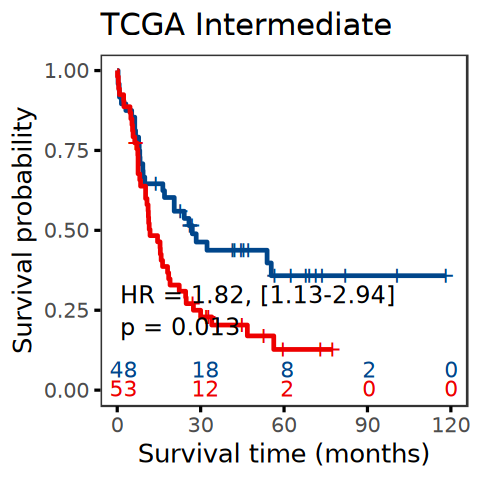

In [22]:
options(repr.plot.width=4, repr.plot.height=4)

cli_TCGA %>% filter(CytogeneticRisk=="Intermediate") %>% KMplot(risk_column = "Risk", title = "TCGA Intermediate")

# System information

In [23]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /cluster2/huanglab/rtang/conda/envs/R4.3/lib/libopenblasp-r0.3.23.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggalluvial_0.12.5  glmnet_4.1-8       Matrix_1.6-5       RColorBrewer_1.1-3
 [5] paletteer_1.5.0    cowplot_1.1.1      survival_3.5-7     survminer_0.4.9   
 [9] ggpubr_0.6.0       dplyr_1.1.3     